# Unsupervised Image-to-Image Translation using Cycle-Consistent Adversarial Networks
Notebook Author: Jin Yeom (jinyeom@utexas.edu)  
Original Authors: Jun-Yan Zhu, Taesung Park, Phillip Isola, Alexei A. Efros

In [1]:
import os
import zipfile
import pathlib

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision import transforms
from torchvision import datasets

import numpy as np
import wget
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
%matplotlib inline

![CycleGAN](images/cyclegan.jpg)

## Datasets

In [2]:
def download_dataset(name: str):
    if name not in {"ae_photos", "apple2orange", "summer2winter_yosemite", "horse2zebra", 
                    "monet2photo", "cezanne2photo", "ukiyoe2photo", "vangogh2photo", "maps", 
                    "cityscapes", "facades", "iphone2dslr_flower", "ae_photos"}:
        raise ValueError("invalid argument dataset name")
        
    try:
        # mkdir datasets/cyclegan if it doesn't exist yet
        pathlib.Path("./datasets/cyclegan").mkdir(parents=True)
    except FileExistsError:
        pass
        
    # download the dataset
    print(f"downloading {name}...", end="", flush=True)
    zip_path = f"./datasets/cyclegan/{name}.zip"
    target_dir = f"./datasets/cyclegan/{name}/"
    url = f"https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/{name}.zip"
    wget.download(url, out=zip_path)
    
    try:
        #mkdir dataset directory and unzip if it doesn't exist
        pathlib.Path(target_dir).mkdir(parents=True)
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall("datasets/cyclegan/")
    except FileExistsError:
        pass
    os.remove(zip_path)
    print("done")

In [3]:
# NOTE: only download if you have to!
download_dataset("apple2orange")
download_dataset("horse2zebra")

downloading apple2orange...done
downloading horse2zebra...done


In [48]:
!ls ./datasets/cyclegan

apple2orange horse2zebra


In [53]:
!ls ./datasets/cyclegan/horse2zebra/

test  train


To make it easier to import the dataset with torchvision, let's restructure the dataset directory a little.

In [50]:
%%bash
for D in `find ./datasets/cyclegan -depth 1 -type d`
do
    mkdir "${D}/train"
    mkdir "${D}/test"
    
    # move trainA and trainB to train/A and train/B
    mv "${D}/trainA" "${D}/train/A"
    mv "${D}/trainB" "${D}/train/B"
    # move testA and testB to test/A and test/B
    mv "${D}/testA" "${D}/test/A"
    mv "${D}/testB" "${D}/test/B"
done

In [51]:
!ls ./datasets/cyclegan/horse2zebra/
!ls ./datasets/cyclegan/horse2zebra/train

test  train
A B


Here, we're going to load the downloaded datasets to work with via **torchvision**. Since the data images are already nicely sized and cropped uniformly, the only transformation we have to do further is normalization.

In [54]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

horse2zebra_train = datasets.ImageFolder(root="./datasets/cyclegan/horse2zebra/train", transform=transform)
train_loader = torch.utils.data.DataLoader(horse2zebra_train, batch_size=16, shuffle=True, num_workers=2)

horse2zebra_test = datasets.ImageFolder(root="./datasets/cyclegan/horse2zebra/test", transform=transform)
test_loader = torch.utils.data.DataLoader(horse2zebra_test, batch_size=16, shuffle=True, num_workers=2)

Now, let's sample some images, and see what they look like!

In [55]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(16, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

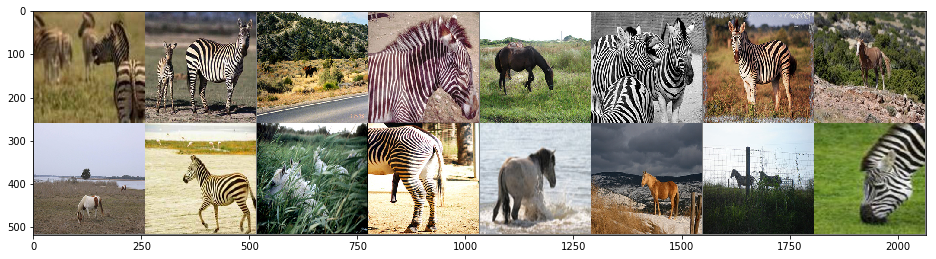

In [56]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images))

## Model

![model](images/CycleGAN.png)

## Generator network

In [24]:
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        super(ResBlock, self).__init__()
        self.pad = nn.ReflectionPad2d((kernel_size - 1) // 2)
        self.conv0 = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        self.norm0 = nn.InstanceNorm2d(out_channels)
        self.conv1 = nn.Conv2d(out_channels, out_channels, kernel_size, stride)
        self.norm1 = nn.InstanceNorm2d(out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.pad(x)
        z = self.conv0(z)
        z = self.norm0(z)
        z = F.relu(z)
        z = self.pad(z)
        z = self.conv1(z)
        z = self.norm1(z)
        return x + z

In [34]:
class Generator(nn.Module):
    def __init__(self, in_channel: int = 3, out_channel: int = 3):
        super(Generator, self).__init__()
        self.pad = nn.ReflectionPad2d(3)
        self.encode = nn.Sequential(nn.Conv2d(in_channel, 32, 7, 1),
                                    nn.InstanceNorm2d(32),
                                    nn.ReLU(),
                                    nn.Conv2d(32, 64, 3, 2),
                                    nn.InstanceNorm2d(64),
                                    nn.ReLU(),
                                    nn.Conv2d(64, 128, 3, 2),
                                    nn.InstanceNorm2d(128),
                                    nn.ReLU())
        self.transform = nn.Sequential(ResBlock(128, 128, 3, 1),
                                       ResBlock(128, 128, 3, 1),
                                       ResBlock(128, 128, 3, 1),
                                       ResBlock(128, 128, 3, 1),
                                       ResBlock(128, 128, 3, 1),
                                       ResBlock(128, 128, 3, 1),
                                       ResBlock(128, 128, 3, 1),
                                       ResBlock(128, 128, 3, 1),
                                       ResBlock(128, 128, 3, 1))
        # TODO: switch from deconvolution to resize-convolution upsampling
        # to avoid checkerboard artifacts (https://distill.pub/2016/deconv-checkerboard/)
        self.decode = nn.Sequential(nn.ConvTranspose2d(128, 64, 3, 2), 
                                    nn.ReLU(),
                                    nn.InstanceNorm2d(64),
                                    nn.ConvTranspose2d(64, 32, 3, 2),
                                    nn.ReLU())
        self.output = nn.Sequential(nn.Conv2d(32, 3, 7, 1), 
                                    nn.InstanceNorm2d(3),
                                    nn.Tanh())
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pad(x)
        x = self.encode(x)
        x = self.transform(x)
        x = self.decode(x)
        x = self.pad(x)
        x = self.output(x)
        return x

## Discriminator network

In [32]:
class Discriminator(nn.Module):
    def __init__(self, in_channel: int = 3, out_channel: int = 1):
        super(Discriminator, self).__init__()
        self.conv0 = nn.Conv2d(in_channel, 64, 7, 2)
        self.conv1 = nn.Conv2d(64, 128, 7, 2)
        self.norm1 = nn.InstanceNorm2d(128)
        self.conv2 = nn.Conv2d(128, 256, 7, 2)
        self.norm2 = nn.InstanceNorm2d(256)
        self.conv3 = nn.Conv2d(256, 512, 7, 2)
        self.norm3 = nn.InstanceNorm2d(512)
        self.conv4 = nn.Conv2d(512, out_channel, 7, 1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv0(x)
        x = F.leaky_relu(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = self.conv4(x)
        return x

## Losses

Two types of loss functions are used to train CycleGAN models: **adversarial losses** for matching the distribution of generated images to the data distribution in the target domain (since we're mapping $A$ to $B$ and $B$ to $A$, we need two adversarial loss functions for each generator function, $G_{AB}: A \rightarrow B$ and $G_{BA}: B \rightarrow A$); and **cycle consistency losses** to prevent the learned mappings between the two input domains from contradicting each other. The loss functions are expressed as follows,

$$\mathcal{L}_{GAN}(G_{AB}, D_B, A, B) = 
    \mathbb{E}_{b \sim p_{data(b)}} \big[ log D_B(b) \big] +
    \mathbb{E}_{a \sim p_{data(a)}} \big[ log(1 - D_B(G(a))) \big]$$

$$\mathcal{L}_{GAN}(G_{BA}, D_A, B, A) = 
    \mathbb{E}_{a \sim p_{data(a)}} \big[ log D_A(a) \big] +
    \mathbb{E}_{b \sim p_{data(b)}} \big[ log(1 - D_A(G(b))) \big]$$

$$\mathcal{L}_{cyc}(G_{AB}, G_{BA}) = 
    \mathbb{E}_{a \sim p_{data(a)}}
        \big[ {\left\lVert G_{BA}(G_{AB}(a)) - a \right\rVert}_1 \big] +
    \mathbb{E}_{b \sim p_{data(b)}}
        \big[ {\left\lVert G_{AB}(G_{BA}(b)) - b \right\rVert}_1 \big]$$

and finally,

$$\mathcal{L}(G_{AB}, G_{BA}, D_A, D_B) = 
    \mathcal{L}_{GAN}(G_{AB}, D_B, A, B)
    + \mathcal{L}_{GAN}(G_{BA}, D_A, B, A)
    + \lambda\mathcal{L}_{cyc}(G_{AB}, G_{BA})$$

Note that the adversarial loss is essentially the **binary cross entropy** between outputs of a discriminator network from real and fake data. Also note that Zhu et al. state in their paper that using a **least-squares loss** instead of the negative log likelihood (BCE) improved stability during training and generates higher quality result. We'll try them ourselves and see the difference!

In [28]:
adv_loss_bce = nn.BCELoss() # binary cross entropy as adversarial loss (negative log likelihood)
adv_loss_mse = nn.MSELoss() # mean squared error as adversarial loss (least-squares loss)
cc_loss = nn.L1Loss() # cycle consistency loss (L1 loss)

## Training

In [37]:
G_AB = Generator()
G_BA = Generator()
D_A = Discriminator()
D_B = Discriminator()

if torch.cuda.is_available():
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()

## References
1. https://arxiv.org/pdf/1703.10593.pdf (Orignal CycleGAN paper)
2. https://arxiv.org/pdf/1603.08155v1.pdf (Perceptual losses and image transformation network)
3. https://arxiv.org/pdf/1607.08022.pdf (Instance normalization)
4. 